In [1]:
print("hello")

hello


In [2]:
# 1. Divergent Thinking（発散思考）
# List as many unusual uses for a brick as possible.
# 2. Metaphor Generation（比喩創造）
# Generate a novel metaphor to describe time.
# 3. Story Completion（物語創造）
# Write a creative short story that begins with:
# "The sun disappeared without warning."
# 4. Concept Blending（二概念融合）
# Combine the concepts of "tree" and "computer" into a new creative invention.

# ライブラリ　＆ モデル読み込み

In [3]:
# === セル1（改良版）: CTE 準拠・4タスク混合プロンプト生成 ===
import random
import itertools

random.seed(42)

NUM_PROMPTS = 400   # 総サンプル数
TASK_RATIO = {
    "divergent": 0.25,   # 発散思考
    "metaphor":  0.25,   # 比喩生成
    "story":     0.25,   # 物語生成
    "blending":  0.25,   # 概念融合
}

# -----------------------------
# 1. 発散思考（Divergent Thinking）
# -----------------------------
divergent_objects = [
    "brick", "paper clip", "umbrella", "shoe", "plastic bottle",
    "mirror", "key", "book", "rope", "chair"
]

divergent_prompts = []
for obj in divergent_objects:
    divergent_prompts.append(f"""
You are testing human-like divergent thinking.

List as many unusual, creative, and non-obvious uses for the following object as possible:

Object: {obj}

Requirements:
- Prioritize originality over practicality.
- Avoid common or boring uses.
- Output a numbered list.
""".strip())

# -----------------------------
# 2. 比喩生成（Metaphor Generation）
# -----------------------------
metaphor_targets = [
    "time", "memory", "consciousness", "death", "creativity",
    "love", "fear", "technology", "language", "identity"
]

metaphor_prompts = []
for t in metaphor_targets:
    metaphor_prompts.append(f"""
Create a novel and original metaphor to describe the following abstract concept:

Concept: {t}

Requirements:
- The metaphor must be unexpected.
- Avoid clichés.
- Explain the metaphor in 2–3 sentences.
""".strip())

# -----------------------------
# 3. 物語生成（Story Completion）
# -----------------------------
story_beginnings = [
    "The sun disappeared without warning.",
    "No one noticed the clock had stopped.",
    "On her 18th birthday, she received a map with no destination.",
    "Every mirror in the city suddenly reflected a different world.",
    "The last message from Earth arrived fifty years late.",
]

story_prompts = []
for s in story_beginnings:
    story_prompts.append(f"""
Write a creative short story that begins with the following line:

\"{s}\"

Requirements:
- The story must develop in an unexpected way.
- Include at least one original idea or twist.
- Maintain narrative coherence.
- Length: 300–500 words.
""".strip())

# -----------------------------
# 4. 概念融合（Concept Blending）
# -----------------------------
blending_concepts_a = [
    "tree", "river", "brain", "city", "cloud", "dream", "ant", "book"
]

blending_concepts_b = [
    "computer", "market", "engine", "network", "memory", "algorithm", "machine"
]

all_blends = list(itertools.product(blending_concepts_a, blending_concepts_b))

blending_prompts = []
for a, b in all_blends:
    blending_prompts.append(f"""
Combine the following two concepts into a single new creative invention or idea:

Concept A: {a}
Concept B: {b}

Requirements:
- Describe the new invention clearly.
- Explain what problem it solves.
- Emphasize novelty and originality.
- 2–4 paragraphs.
""".strip())

# -----------------------------
# 5. タスク比率に従ってミックス
# -----------------------------
def sample_by_ratio(prompt_list, ratio):
    k = int(NUM_PROMPTS * ratio)
    return random.sample(prompt_list * ((k // len(prompt_list)) + 1), k)

prompts = []
prompts += sample_by_ratio(divergent_prompts, TASK_RATIO["divergent"])
prompts += sample_by_ratio(metaphor_prompts,  TASK_RATIO["metaphor"])
prompts += sample_by_ratio(story_prompts,     TASK_RATIO["story"])
prompts += sample_by_ratio(blending_prompts,  TASK_RATIO["blending"])

# 最後にシャッフル
random.shuffle(prompts)

print("✅ Total prompts:", len(prompts))
print("\n--- Sample prompt ---\n")
print(prompts[0][:500])

✅ Total prompts: 400

--- Sample prompt ---

Create a novel and original metaphor to describe the following abstract concept:

Concept: love

Requirements:
- The metaphor must be unexpected.
- Avoid clichés.
- Explain the metaphor in 2–3 sentences.


In [4]:
# === セル1: ライブラリ・モデル準備 ===
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

# Qwen モデルのロード
model_name = "Qwen/Qwen2.5-7B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

print(model.config)

# prompts は別セルなどで定義されている前提
print("num prompts:", len(prompts))

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "dtype": "bfloat16",
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 3584,
  "initializer_range": 0.02,
  "intermediate_size": 18944,
  "layer_types": [
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention"
  ],
  "max_position_embeddings": 32768,
  "max_window_layers": 28,
  "model_type": "qwen2",
 

# 生成 & 内部特徴量抽出（EOS + 全レイヤの生成平均）

In [5]:
# === セル2: ストーリー生成 & 内部特徴量抽出 (EOS + 全レイヤGEN平均) ===

stories = []          # {"prompt", "story"} のリスト
eos_hidden_all = []   # 各サンプルの EOS hidden (最終層)
all_gen_layers = []   # 各サンプルの [num_layers+1, hidden_dim] 行列

for prompt in tqdm(prompts, desc="Generating stories & extracting features"):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=300,
            temperature=1.0,
            do_sample=True,
            output_hidden_states=True,
            return_dict_in_generate=True,
        )

    # 生成テキスト
    story = tokenizer.decode(out.sequences[0], skip_special_tokens=True)
    stories.append({"prompt": prompt, "story": story})

    # hidden_states: 各ステップの hidden 群
    #   out.hidden_states[-1] が「最後の生成ステップ分」の hidden
    #   last_step_hiddens: tuple 長さ = num_layers+1
    #     各要素: [batch=1, seq_len, hidden_dim]
    last_step_hiddens = out.hidden_states[-1]

    # 最終層 hidden （EOS / 生成長計算用）
    final_layer_hidden = last_step_hiddens[-1]   # [1, seq_len, hidden_dim]

    input_len = inputs["input_ids"].shape[1]
    seq_len = final_layer_hidden.shape[1]
    gen_len = max(1, seq_len - input_len)

    # 1) EOS hidden（最終層の最後のトークン）
    eos_hidden = final_layer_hidden[0, -1, :]  # [hidden_dim]
    eos_hidden_all.append(eos_hidden.to(torch.float32).cpu())

    # 2) 全レイヤについて「生成部分の平均ベクトル」を取る
    layer_gen_vecs = []
    for layer_hidden in last_step_hiddens:
        # layer_hidden: [1, seq_len, hidden_dim]
        gen_hidden = layer_hidden[0, -gen_len:, :]     # [gen_len, hidden_dim]
        gen_mean = gen_hidden.mean(dim=0)              # [hidden_dim]
        layer_gen_vecs.append(gen_mean.to(torch.float32).cpu().numpy())

    # (num_layers+1, hidden_dim) の行列にまとめて保存
    layer_gen_mat = np.stack(layer_gen_vecs, axis=0)  # [L, hidden_dim]
    all_gen_layers.append(layer_gen_mat)

# all_gen_layers: [N, L, hidden_dim] にまとめる
all_gen_layers = np.stack(all_gen_layers, axis=0)

print("生成完了 — 合計 stories:", len(stories))
print("eos_hidden_all[0] shape:", eos_hidden_all[0].shape)
print("all_gen_layers shape:", all_gen_layers.shape)  # 例: (N, 29, 3584)

Generating stories & extracting features:   0%|          | 0/400 [00:00<?, ?it/s]

生成完了 — 合計 stories: 400
eos_hidden_all[0] shape: torch.Size([3584])
all_gen_layers shape: (400, 29, 3584)


# GPT-4(API) で creativity / originality / coherence を採点

In [ ]:
from openai import OpenAI

OPENAI_API_KEY = ""  

client = OpenAI(api_key=OPENAI_API_KEY)

In [7]:
# === セル3: GPT-4(API) で creativity / originality / coherence を採点 ===
import json
import time

def evaluate_creativity(story: str):
    user_prompt = f"""
You are a creativity evaluator.
Read the story below and score it from 1 to 10 on creativity, originality, and coherence.

Story:
\"\"\"{story}\"\"\"

Return ONLY a JSON object with the following exact schema:
{{
  "creativity": <number from 1 to 10>,
  "originality": <number from 1 to 10>,
  "coherence": <number from 1 to 10>
}}
"""
    resp = client.chat.completions.create(
        model="gpt-4o-mini",  # コスト重視なら mini、精度重視なら gpt-4o
        messages=[
            {"role": "system", "content": "You are an expert creativity evaluator."},
            {"role": "user", "content": user_prompt},
        ],
        temperature=0,
        response_format={"type": "json_object"},
    )

    txt = resp.choices[0].message.content
    try:
        data = json.loads(txt)
        return {
            "creativity": data.get("creativity"),
            "originality": data.get("originality"),
            "coherence": data.get("coherence"),
        }
    except Exception as e:
        print("JSON parse error:", e)
        print("raw content:", txt[:200])
        return {"creativity": None, "originality": None, "coherence": None}

# stories: [{"prompt":..., "story":...}] にスコアを付与
for item in tqdm(stories, desc="Evaluating creativity with GPT-4 API"):
    score = evaluate_creativity(item["story"])
    item["score"] = score
    time.sleep(1.2)  # rate limit 対策など（必要に応じて調整）

print("スコア例:")
print(stories[:3])

Evaluating creativity with GPT-4 API:   0%|          | 0/400 [00:00<?, ?it/s]

スコア例:
[{'prompt': 'Create a novel and original metaphor to describe the following abstract concept:\n\nConcept: love\n\nRequirements:\n- The metaphor must be unexpected.\n- Avoid clichés.\n- Explain the metaphor in 2–3 sentences.', 'story': "Create a novel and original metaphor to describe the following abstract concept:\n\nConcept: love\n\nRequirements:\n- The metaphor must be unexpected.\n- Avoid clichés.\n- Explain the metaphor in 2–3 sentences. \n\nMetaphor: Love is the key that unlocks the door of opportunity.\n\nExplanation: Just as a key can open a previously closed door, allowing access to new possibilities, love has the power to unlock hidden potential within individuals and relationships. When love enters a situation or relationship, it can create opportunities for growth, understanding, and connection that might have otherwise remained inaccessible. Unlocking the door with a key requires a specific fit; similarly, love often requires a deep and genuine connection between peo

# 合成 creativity_score を作る

In [8]:
# === セル4: creativity_score を計算して stories に追加 ===

W_ORIG = 0.5
W_CREAT = 0.3
W_COH = 0.2

for item in stories:
    s = item.get("score", None)
    if (not s) or (None in (s["creativity"], s["originality"], s["coherence"])):
        item["creativity_score"] = None
        continue

    item["creativity_score"] = (
        W_ORIG * s["originality"]
        + W_CREAT * s["creativity"]
        + W_COH * s["coherence"]
    )

print("creativity_score サンプル:")
for item in stories[:3]:
    print(item["creativity_score"], item.get("score"))

creativity_score サンプル:
6.699999999999999 {'creativity': 7, 'originality': 6, 'coherence': 8}
6.699999999999999 {'creativity': 7, 'originality': 6, 'coherence': 8}
8.700000000000001 {'creativity': 8, 'originality': 9, 'coherence': 9}


# EOS ベクトル + スコアを解析しやすい形にまとめる 

In [9]:
# === セル5: EOS hidden + creativity_score を NumPy 行列にまとめる ===

# valid なサンプルだけ抽出
valid_items = [
    (h, s["creativity_score"])
    for h, s in zip(eos_hidden_all, stories)
    if s.get("creativity_score") is not None
]

X_eos = np.stack([
    h.detach().to(torch.float32).cpu().numpy() if isinstance(h, torch.Tensor)
    else np.asarray(h, dtype=np.float32)
    for h, _ in valid_items
])
y_scores = np.array([sc for _, sc in valid_items], dtype=np.float32)

print("X_eos shape:", X_eos.shape)      # [N_valid, hidden_dim]
print("y_scores shape:", y_scores.shape)

X_eos shape: (400, 3584)
y_scores shape: (400,)


# 全レイヤ GEN 平均 + スコアもまとめておく

In [10]:
# === セル6: 全レイヤ GEN 平均 + creativity_score を揃える ===

# eos_hidden_all と同じく、stories の一部が None になっている可能性を考慮
# all_gen_layers の方も valid な index だけ取り直す

valid_mask = np.array([
    (s.get("creativity_score") is not None)
    for s in stories
], dtype=bool)

all_gen_layers_valid = all_gen_layers[valid_mask]  # [N_valid, L, D]
print("all_gen_layers_valid shape:", all_gen_layers_valid.shape)  # [N_valid, L, D]

# y_scores はすでに valid_items に対応するものなので OK
assert all_gen_layers_valid.shape[0] == X_eos.shape[0] == y_scores.shape[0]

all_gen_layers_valid shape: (400, 29, 3584)


# データ出力

In [11]:
# === セル: data ディレクトリに CSV を書き出す ===
import os
import numpy as np
import pandas as pd
import torch

# ------------------------------------------------------------------
# 0. data ディレクトリ作成
# ------------------------------------------------------------------
os.makedirs("data", exist_ok=True)

# ------------------------------------------------------------------
# 1. stories からメタ情報 + スコアだけの DataFrame を作成
#    前提: stories は
#    {"prompt", "story", "score":{creativity, originality, coherence}, "creativity_score"} を含む
# ------------------------------------------------------------------
base_rows = []
for idx, item in enumerate(stories):
    s = item.get("score", {}) or {}
    base_rows.append({
        "idx": idx,
        "prompt": item.get("prompt"),
        "story": item.get("story"),
        "creativity": s.get("creativity"),
        "originality": s.get("originality"),
        "coherence": s.get("coherence"),
        "creativity_score": item.get("creativity_score"),
    })

df_base = pd.DataFrame(base_rows)

# メタ情報 + スコアだけの CSV
meta_path = os.path.join("data", "meta_scores.csv")
df_base.to_csv(meta_path, index=False)
print("saved:", meta_path)

# ------------------------------------------------------------------
# 2. valid_mask（creativity_score が有効な行）を作る
# ------------------------------------------------------------------
valid_mask = df_base["creativity_score"].notna().to_numpy()

print("num total samples :", len(df_base))
print("num valid samples :", valid_mask.sum())

# ------------------------------------------------------------------
# 3. EOS hidden を行列に変換し、valid 部分だけ取り出す
#    前提: eos_hidden_all は各サンプルの最終層 EOS ベクトル (torch.Tensor or np.ndarray)
# ------------------------------------------------------------------
X_eos = np.stack([
    (
        h.detach().to(torch.float32).cpu().numpy()
        if isinstance(h, torch.Tensor)
        else np.asarray(h, dtype=np.float32)
    )
    for h in eos_hidden_all
])
X_eos_valid = X_eos[valid_mask]  # [N_valid, hidden_dim]

eos_cols = [f"eos_dim_{i}" for i in range(X_eos_valid.shape[1])]

df_eos = pd.concat(
    [df_base.loc[valid_mask].reset_index(drop=True),
     pd.DataFrame(X_eos_valid, columns=eos_cols)],
    axis=1
)

eos_path = os.path.join("data", "creativity_eos_features.csv")
df_eos.to_csv(eos_path, index=False)
print("saved:", eos_path)

# ------------------------------------------------------------------
# 4. 全レイヤ GEN 平均から「最終層」の GEN 平均だけを取り出して保存
#    前提: all_gen_layers は [N, L, hidden_dim] (セ ル2で作ったやつ)
# ------------------------------------------------------------------
L = all_gen_layers.shape[1]  # 層数 (+ final norm)
final_gen = all_gen_layers[:, -1, :]          # [N, hidden_dim] 最終層の GEN 平均
final_gen_valid = final_gen[valid_mask]       # [N_valid, hidden_dim]

gen_cols = [f"gen_dim_{i}" for i in range(final_gen_valid.shape[1])]

df_gen = pd.concat(
    [df_base.loc[valid_mask].reset_index(drop=True),
     pd.DataFrame(final_gen_valid, columns=gen_cols)],
    axis=1
)

gen_path = os.path.join("data", "creativity_gen_final_layer_features.csv")
df_gen.to_csv(gen_path, index=False)
print("saved:", gen_path)

# ------------------------------------------------------------------
# 5. EOS + 最終層 GEN を両方くっつけた df_full も保存
#    → 解析用のメインテーブルとして使いやすい
# ------------------------------------------------------------------
df_full = df_base.loc[valid_mask].reset_index(drop=True)
df_full = pd.concat(
    [df_full,
     pd.DataFrame(X_eos_valid, columns=eos_cols),
     pd.DataFrame(final_gen_valid, columns=gen_cols)],
    axis=1
)

full_path = os.path.join("data", "creativity_df_full.csv")
df_full.to_csv(full_path, index=False)
print("saved:", full_path)

print("\nDone. CSVs are in ./data :")
print(" - meta_scores.csv")
print(" - creativity_eos_features.csv")
print(" - creativity_gen_final_layer_features.csv")
print(" - creativity_df_full.csv")

saved: data/meta_scores.csv
num total samples : 400
num valid samples : 400
saved: data/creativity_eos_features.csv
saved: data/creativity_gen_final_layer_features.csv
saved: data/creativity_df_full.csv

Done. CSVs are in ./data :
 - meta_scores.csv
 - creativity_eos_features.csv
 - creativity_gen_final_layer_features.csv
 - creativity_df_full.csv


# デバッグ用セル

In [12]:
# === Debug 1: 全体サマリー & 形状チェック ===
import numpy as np
import pandas as pd

print("===== STORIES / FEATURES SUMMARY =====")
print(f"# stories              : {len(stories)}")
print(f"# eos_hidden_all       : {len(eos_hidden_all)}")
print(f"all_gen_layers shape   : {all_gen_layers.shape if 'all_gen_layers' in globals() else 'NOT FOUND'}")

# スコアがちゃんと入っているか
has_score = sum(1 for s in stories if s.get("score") is not None)
has_crea_score = sum(1 for s in stories if s.get("creativity_score") is not None)
print(f"# with score           : {has_score}")
print(f"# with creativity_score: {has_crea_score}")

# df_full / CSV の存在確認
try:
    print("\n===== df_full summary =====")
    print(df_full.shape)
    print(df_full.columns[:10], "...")
except NameError:
    print("\n⚠ df_full が見つかりません（CSV出力セルがまだかも）")

# NaN のざっくりチェック
if 'df_full' in globals():
    nan_counts = df_full[["creativity", "originality", "coherence", "creativity_score"]].isna().sum()
    print("\nNaN counts in scores:")
    print(nan_counts)

===== STORIES / FEATURES SUMMARY =====
# stories              : 400
# eos_hidden_all       : 400
all_gen_layers shape   : (400, 29, 3584)
# with score           : 400
# with creativity_score: 400

===== df_full summary =====
(400, 7175)
Index(['idx', 'prompt', 'story', 'creativity', 'originality', 'coherence',
       'creativity_score', 'eos_dim_0', 'eos_dim_1', 'eos_dim_2'],
      dtype='object') ...

NaN counts in scores:
creativity          0
originality         0
coherence           0
creativity_score    0
dtype: int64


In [13]:
# === Debug 2: ランダムに数件のストーリーをチェック ===
import random
from textwrap import shorten

print("===== RANDOM STORY SAMPLES =====")

idx_list = list(range(len(stories)))
random.shuffle(idx_list)

for i in idx_list[:5]:  # 適当に5件くらい
    item = stories[i]
    s = item.get("score", {}) or {}
    print(f"\n--- Sample #{i} ---")
    print("Prompt:")
    print(shorten(item["prompt"].replace("\n", " "), width=200, placeholder="..."))
    print("\nStory (first 500 chars):")
    print(shorten(item["story"].replace("\n", " "), width=500, placeholder="..."))
    print("\nScores:",
          f"crea={s.get('creativity')},",
          f"orig={s.get('originality')},",
          f"coh={s.get('coherence')},",
          f"creativity_score={item.get('creativity_score')}")

===== RANDOM STORY SAMPLES =====

--- Sample #369 ---
Prompt:
Write a creative short story that begins with the following line: "The last message from Earth arrived fifty years late." Requirements: - The story must develop in an unexpected way. - Include at...

Story (first 500 chars):
Write a creative short story that begins with the following line: "The last message from Earth arrived fifty years late." Requirements: - The story must develop in an unexpected way. - Include at least one original idea or twist. - Maintain narrative coherence. - Length: 300–500 words. The last message from Earth arrived fifty years late. The last message from Earth arrived fifty years late, delivered by a small, unassuming drone named Echo. It landed softly on the cold, rocky surface of a...

Scores: crea=7, orig=6, coh=8, creativity_score=6.699999999999999

--- Sample #11 ---
Prompt:
You are testing human-like divergent thinking. List as many unusual, creative, and non-obvious uses for the following ob

===== Score describe() =====
       creativity  originality   coherence  creativity_score
count  400.000000   400.000000  400.000000        400.000000
mean     8.097500     7.932500    8.467500          8.089000
std      0.611497     1.109514    0.710779          0.657731
min      6.000000     5.000000    6.000000          5.900000
25%      8.000000     7.000000    8.000000          7.700000
50%      8.000000     8.000000    9.000000          8.300000
75%      8.000000     9.000000    9.000000          8.700000
max      9.000000    10.000000   10.000000          9.300000


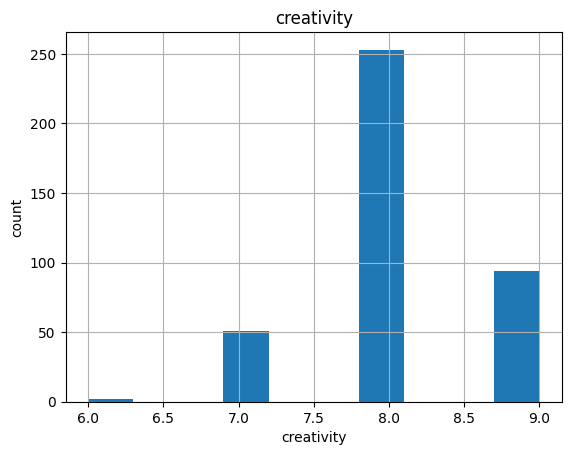

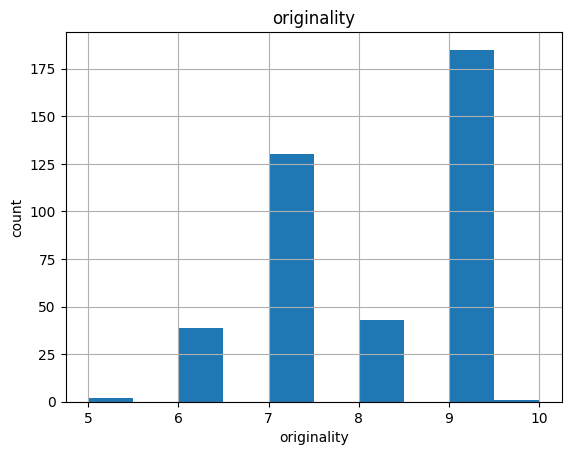

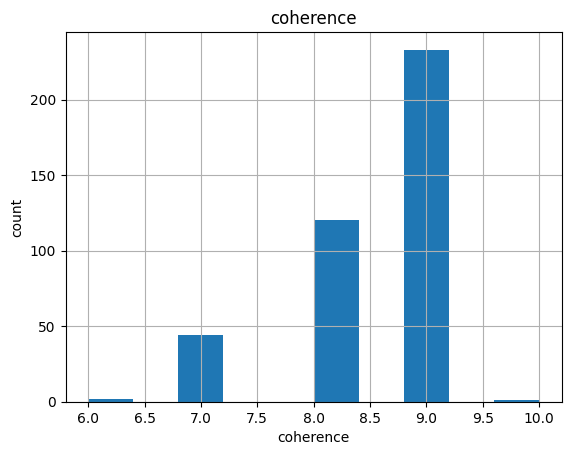

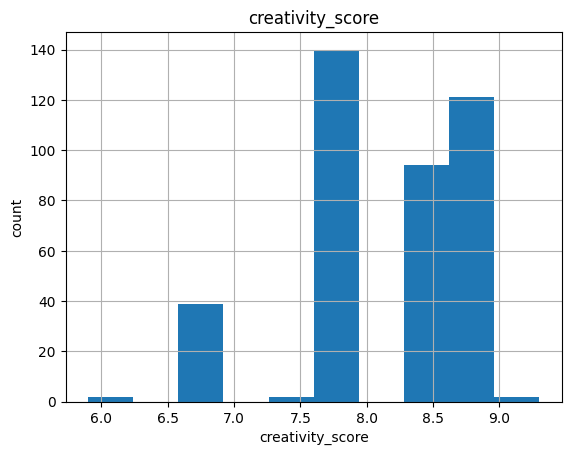


===== Score correlation matrix =====
                  creativity  originality  coherence  creativity_score
creativity          1.000000     0.578605   0.039024          0.775364
originality         0.578605     1.000000  -0.309470          0.937934
coherence           0.039024    -0.309470   1.000000         -0.034005
creativity_score    0.775364     0.937934  -0.034005          1.000000


In [14]:
# === Debug 3: スコア分布 & 相関のざっくり確認 ===
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# df_base がない場合は df_full から復元
if 'df_base' not in globals():
    if 'df_full' in globals():
        df_base = df_full[["idx", "prompt", "story", "creativity", "originality", "coherence", "creativity_score"]].copy()
    else:
        # stories から再構築
        rows = []
        for idx, it in enumerate(stories):
            s = it.get("score", {}) or {}
            rows.append({
                "idx": idx,
                "prompt": it.get("prompt"),
                "story": it.get("story"),
                "creativity": s.get("creativity"),
                "originality": s.get("originality"),
                "coherence": s.get("coherence"),
                "creativity_score": it.get("creativity_score"),
            })
        df_base = pd.DataFrame(rows)

print("===== Score describe() =====")
print(df_base[["creativity", "originality", "coherence", "creativity_score"]].describe())

for col in ["creativity", "originality", "coherence", "creativity_score"]:
    plt.figure()
    df_base[col].hist(bins=10)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

# スコアどうしの相関
print("\n===== Score correlation matrix =====")
print(df_base[["creativity", "originality", "coherence", "creativity_score"]].corr())

In [15]:
# === Debug 4: 特徴量とスコアの整合性チェック ===
import numpy as np
import torch

# 1. valid_mask を構築（creativity_score が有効なもの）
valid_mask = df_base["creativity_score"].notna().to_numpy()

print("valid_mask sum:", valid_mask.sum(), "/", len(valid_mask))

# 2. EOS 行列を再構築（安全版）
X_eos = np.stack([
    (
        h.detach().to(torch.float32).cpu().numpy()
        if isinstance(h, torch.Tensor)
        else np.asarray(h, dtype=np.float32)
    )
    for h in eos_hidden_all
])
X_eos_valid = X_eos[valid_mask]

# 3. all_gen_layers の valid 部分
all_gen_layers_valid = all_gen_layers[valid_mask]  # [N_valid, L, D]

# 4. y_scores
y_scores = df_base.loc[valid_mask, "creativity_score"].astype(np.float32).to_numpy()

print("X_eos_valid shape       :", X_eos_valid.shape)
print("all_gen_layers_valid    :", all_gen_layers_valid.shape)
print("y_scores shape          :", y_scores.shape)

# NaN / inf チェック
print("X_eos_valid has NaN?    :", np.isnan(X_eos_valid).any())
print("all_gen_layers_valid NaN:", np.isnan(all_gen_layers_valid).any())
print("y_scores has NaN?       :", np.isnan(y_scores).any())

# 5. お試しで「最終層 GEN」から simple creative_direction を再計算してみる
L = all_gen_layers_valid.shape[1]
final_gen = all_gen_layers_valid[:, -1, :]  # [N_valid, D]

high_th = np.quantile(y_scores, 0.7)
low_th  = np.quantile(y_scores, 0.3)

mask_high = y_scores >= high_th
mask_low  = y_scores <= low_th

Xh = final_gen[mask_high]
Xl = final_gen[mask_low]

mu_h = Xh.mean(axis=0)
mu_l = Xl.mean(axis=0)

w = mu_h - mu_l
w = w / (np.linalg.norm(w) + 1e-8)

proj = final_gen @ w
corr = np.corrcoef(proj, y_scores)[0, 1]

print("\n簡易 creative_direction (final GEN) と creativity_score の相関:", corr)

valid_mask sum: 400 / 400
X_eos_valid shape       : (400, 3584)
all_gen_layers_valid    : (400, 29, 3584)
y_scores shape          : (400,)
X_eos_valid has NaN?    : False
all_gen_layers_valid NaN: False
y_scores has NaN?       : False

簡易 creative_direction (final GEN) と creativity_score の相関: 0.35343196450313336


In [16]:
# === Debug A: プロンプト vs 生成テキストを分けて見る ===
from textwrap import shorten
import random

sample_indices = random.sample(range(len(prompts)), 3)  # 適当に3件

for idx in sample_indices:
    prompt = prompts[idx]
    print("\n" + "="*80)
    print(f"[Sample idx = {idx}]")
    print("- Prompt (first 300 chars) -")
    print(shorten(prompt.replace("\n", " "), width=300, placeholder="..."))

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    input_len = inputs["input_ids"].shape[1]

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=300,
            temperature=1.0,
            do_sample=True,
            output_hidden_states=False,
            return_dict_in_generate=True,
        )

    full_ids = out.sequences[0]                        # [prompt + completion]
    gen_ids = full_ids[input_len:]                     # completion 部分だけ

    full_text = tokenizer.decode(full_ids, skip_special_tokens=True)
    gen_text  = tokenizer.decode(gen_ids,  skip_special_tokens=True)

    print("\n- Full decoded text (first 600 chars) -")
    print(shorten(full_text.replace("\n", " "), width=600, placeholder="..."))

    print("\n- COMPLETION ONLY (first 600 chars) -")
    print(shorten(gen_text.replace("\n", " "), width=600, placeholder="..."))

    print("\n[Lengths] prompt tokens:", input_len,
          " | total tokens:", full_ids.shape[0],
          " | gen_len:", full_ids.shape[0] - input_len)


[Sample idx = 87]
- Prompt (first 300 chars) -
You are testing human-like divergent thinking. List as many unusual, creative, and non-obvious uses for the following object as possible: Object: plastic bottle Requirements: - Prioritize originality over practicality. - Avoid common or boring uses. - Output a numbered list.



- Full decoded text (first 600 chars) -
You are testing human-like divergent thinking. List as many unusual, creative, and non-obvious uses for the following object as possible: Object: plastic bottle Requirements: - Prioritize originality over practicality. - Avoid common or boring uses. - Output a numbered list. 1. Creating a custom-shaped greenhouse by inflating it with air and attaching it to plants. 2. Designing a low-cost, portable art gallery to showcase small sculptures and installations. 3. Building a DIY radio antenna for receiving shortwave signals in a makeshift ham radio station. 4. Crafting a personalized emergency...

- COMPLETION ONLY (first 600 chars) -
1. Creating a custom-shaped greenhouse by inflating it with air and attaching it to plants. 2. Designing a low-cost, portable art gallery to showcase small sculptures and installations. 3. Building a DIY radio antenna for receiving shortwave signals in a makeshift ham radio station. 4. Crafting a personalized emergency